# DDPG
> Experiment list: Baseline, Pure Diff Vectors

In [2]:
import pandas as pd
import numpy as np
import itertools
from tqdm.notebook import tqdm
import pickle

import torch
import torch.utils.data as data
from torch.utils.data import DataLoader
import torch.utils.data.sampler as sampler
import torch.nn as nn
import torch.nn.functional as F

from matplotlib import pyplot as plt
from collections import defaultdict
import warnings
from sklearn.preprocessing import LabelEncoder
import random
from datetime import datetime
import pytz
import line_profiler
from functools import reduce

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
!pip list |grep torch

botorch                  0.2.1
gpytorch                 1.6.0
torch                    1.10.0
torchvision              0.6.1+cu101


### Fix Random Seeds

In [4]:
def same_seeds(seed):
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
  np.random.seed(seed)  
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True

same_seeds(0)

## Prepare Data

### Available Files

||Title|File Name|
|---|-----|---------|
|order|Stream group by streamers|`streamer_stream_dict.pkl`|
||Stream list|`stream_list.pkl`|
|Context|Final user context|`user_context.pkl`|
||Streamer context|`streamer.pkl`|
||Item context|`item_pca_df.pkl`|
|Aux|stream: items list|`stream_item_dict.pkl`|
||stream: users list|`stream_users_dict.pkl`|
||item list the consumer actually bought|`user_bought_dict.pkl`|
|Explore-Diff|PCA based diff vector|`diff_vectors_pca.pkl`|
||SVD based diff vector|`diff_vectors_svd.pkl`|
||VAE based diff vector|`diff_vectors_vae.pkl`|
|Threshold|VAE reconstruction error df|`vae_recons_df.pkl`|

In [5]:
# STREAMER_STREAM_DICT = pd.read_pickle('../../data/streamer_stream_dict.pkl')
STREAM_LIST = pd.read_pickle('../../data/stream_list.pkl')
USER_CONTEXT = pd.read_pickle('../../data/user_context.pkl')
# STREAMER = pd.read_pickle('../../data/streamer.pkl')
ITEM_PCA_DF = pd.read_pickle('../../data/item_pca_df.pkl')
STREAM_ITEM_DICT = pd.read_pickle('../../data/stream_item_dict.pkl')
USER_BOUGHT_DICT = pd.read_pickle('../../data/user_bought_dict.pkl')
STREAM_USER_DICT = pd.read_pickle('../../data/stream_users_dict.pkl')
# Current used diff
ITEM_DIFF = pd.read_pickle('../../data/item_diff_vectors.pkl')
STREAM_ORDER_CNT = pd.read_pickle('../../data/stream_order_cnt_list.pkl')

In [6]:
DIFF_PCA = pd.read_pickle('../../data/diff_vectors_pca.pkl')
# DIFF_SVD = pd.read_pickle('../../data/diff_vectors_svd.pkl')
# DIFF_VAE = pd.read_pickle('../../data/diff_vectors_vae.pkl')
# VAE_RECONS_DF = pd.read_pickle('../../data/vae_recons_df.pkl')
# VAE_RECONS64_DF = pd.read_pickle('../../data/vae_recons_64_df.pkl')
# MUL150_PCA = pd.read_pickle('../../data/mul150_pca_diff.pkl')
# MUL150_VAE = pd.read_pickle('../../data/mul150_vae_diff.pkl')
# MUL64_PCA = pd.read_pickle('../../data/mul64_pca_diff.pkl')
# MUL64_VAE = pd.read_pickle('../../data/mul64_vae_diff.pkl')

---

## Replay

In [7]:
class RingBuffer(object):
    def __init__(self, maxlen):
        self.maxlen = maxlen
        self.start = 0
        self.length = 0
        self.data = [None for _ in range(maxlen)]

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        if idx < 0 or idx >= self.length:
            raise KeyError()
        return self.data[(self.start + idx) % self.maxlen]

    def append(self, v):
        if self.length < self.maxlen:
            # We have space, simply increase the length.
            self.length += 1
        elif self.length == self.maxlen:
            # No space, "remove" the first item.
            self.start = (self.start + 1) % self.maxlen
        else:
            # This should never happen.
            raise RuntimeError()
        self.data[(self.start + self.length - 1) % self.maxlen] = v

class ReplayBuffer:
  def __init__(self, limit=10000):
    self.limit = limit
    # init 4 RingBuffers: states/actions/rewards/ongoing
    self.states_buffer = RingBuffer(limit)
    self.next_states_buffer = RingBuffer(limit)
    self.actions_buffer = RingBuffer(limit)
    self.rewards_buffer = RingBuffer(limit)
    self.ongoings_buffer = RingBuffer(limit)
    
  def __len__(self):
    assert len(self.states_buffer) == len(self.next_states_buffer) == len(self.actions_buffer) == \
           len(self.rewards_buffer) == len(self.ongoings_buffer)
    return len(self.states_buffer)

  def remember(self, state, actions, reward, next_state, ongoing):
    assert len(self.states_buffer) == len(self.next_states_buffer) == len(self.actions_buffer) == \
           len(self.rewards_buffer) == len(self.ongoings_buffer)
    # append each element separately in different list
    self.states_buffer.append(state)
    self.actions_buffer.append(actions)
    self.rewards_buffer.append(reward)
    self.next_states_buffer.append(next_state)
    self.ongoings_buffer.append(ongoing)
    
  def get_batch(self, batch_size=100):
    assert len(self.states_buffer) == len(self.next_states_buffer) == len(self.actions_buffer) == \
           len(self.rewards_buffer) == len(self.ongoings_buffer)
    # same for sample_and_split
    states0_batch = []
    states1_batch = []
    actions_batch = []
    rewards_batch = []
    ongoings_batch = []
    batch_indexs = np.random.randint(0, len(self.states_buffer), size=min(len(self.states_buffer), batch_size))
    for i in batch_indexs:
      states0_batch.append(USER_CONTEXT.xs(self.states_buffer[i]))
      states1_batch.append(USER_CONTEXT.xs(self.next_states_buffer[i]))
      actions_batch.append(self.actions_buffer[i])
      rewards_batch.append(self.rewards_buffer[i])
      ongoings_batch.append(self.ongoings_buffer[i])
    assert len(states0_batch) == len(states1_batch) == len(actions_batch) == \
           len(rewards_batch) == len(ongoings_batch)
    return np.array(states0_batch), np.array(actions_batch), np.array(rewards_batch), np.array(states1_batch), np.array(ongoings_batch)

In [8]:
from abc import ABC, abstractmethod
import math

class Epsilon(ABC):
  @abstractmethod
  def clear(self):
    pass
  
  @abstractmethod
  def get_epsilon(self, key):
    pass
  
  @abstractmethod
  def update_at_step(self, key, data, delta):
    pass
  
  @abstractmethod
  def update_at_epoch(self, data):
    pass

class Decay(Epsilon):
  # Ref: Decay(0.5, 0.85)
  '''
  Epsilon Decay EE method with update/decay at epoch
  '''
  def __init__(self, initial, epoch_decay=1.0, step_decay=1.0):
    self.initial = initial
    self.epoch_decay, self.step_decay = epoch_decay, step_decay
    self.epsilon = self.initial
    
  def clear(self):
    self.epsilon = self.initial # should be 4 for origin setting
    
  def get_epsilon(self, key):
    return self.epsilon
  
  def update_at_step(self, key, data, delta):
    # origin setting
    # pass
    # exponentially
    i = data[1]
    self.epsilon = 4 / ((i + 1) ** (1 / 4))
    
  def update_at_epoch(self, data):
    # origin settings
    # epoch = data
    # self.epsilon = 4 / ((epoch + 1) ** (1 / 2))
    # exponentially
    self.epsilon *= self.epoch_decay


class VDBE(Epsilon):
  # VDBE(0.5, 0.01)
  def __init__(self, initial, sigma):
    self.initial = initial
    self.sigma = sigma

  def clear(self):
    self.epsilon = defaultdict(lambda: self.initial)

  def get_epsilon(self, key):
    return self.epsilon[key]
  
  def update_at_step(self, key, data, delta):
    td_error = data[0]
    coeff = math.exp(-abs(td_error) / self.sigma)
    f = (1.0 - coeff) / (1.0 + coeff)
    self.epsilon[key] = delta * f + (1.0 - delta) * self.epsilon[key]
  
  def update_at_epoch(self, data):
    pass

## Random Process

In [9]:
class RandomProcess(object):
    def reset_states(self):
        pass

class AnnealedGaussianProcess(RandomProcess):
    def __init__(self, mu, sigma, sigma_min, n_steps_annealing):
        self.mu = mu
        self.sigma = sigma
        self.n_steps = 0

        if sigma_min is not None:
            self.m = -float(sigma - sigma_min) / float(n_steps_annealing)
            self.c = sigma
            self.sigma_min = sigma_min
        else:
            self.m = 0.
            self.c = sigma
            self.sigma_min = sigma

    @property
    def current_sigma(self):
        sigma = max(self.sigma_min, self.m * float(self.n_steps) + self.c)
        return sigma


# Based on http://math.stackexchange.com/questions/1287634/implementing-ornstein-uhlenbeck-in-matlab
class OrnsteinUhlenbeckProcess(AnnealedGaussianProcess):
    def __init__(self, theta, mu=0., sigma=1., dt=1e-2, x0=None, size=1, sigma_min=None, n_steps_annealing=1000):
        super(OrnsteinUhlenbeckProcess, self).__init__(mu=mu, sigma=sigma, sigma_min=sigma_min, n_steps_annealing=n_steps_annealing)
        self.theta = theta
        self.mu = mu
        self.dt = dt
        self.x0 = x0
        self.size = size
        self.reset_states()

    def sample(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + self.current_sigma * np.sqrt(self.dt) * np.random.normal(size=self.size)
        self.x_prev = x
        self.n_steps += 1
        return x

    def reset_states(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros(self.size)

## Models

In [10]:
def fanin_init(size, fanin=None):
    fanin = fanin or size[0]
    v = 1. / np.sqrt(fanin)
    return torch.Tensor(size).uniform_(-v, v)

class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, mode, hidden1=400, hidden2=300, init_w=3e-3):
        super(Actor, self).__init__()
        self.mode = mode
        self.fc1 = nn.Linear(state_dim, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, action_dim)
        self.norm = nn.LayerNorm(hidden1)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.init_weights(init_w)
    
    def init_weights(self, init_w):
        self.fc1.weight.data = fanin_init(self.fc1.weight.data.size())
        self.fc2.weight.data = fanin_init(self.fc2.weight.data.size())
        self.fc3.weight.data.uniform_(-init_w, init_w)
    
    def forward(self, x):
        out = self.fc1(x)
        if self.mode == 'PARAM_NOISE': out = self.norm(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.tanh(out)
        return out

    def add_parameter_noise(self, scalar=.1):
        self.fc1.weight.data += torch.randn_like(self.fc1.weight.data) * scalar
        self.fc2.weight.data += torch.randn_like(self.fc2.weight.data) * scalar
        self.fc3.weight.data += torch.randn_like(self.fc3.weight.data) * scalar


class Critic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden1=400, hidden2=300, init_w=3e-3):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden1)
        self.fc2 = nn.Linear(hidden1+action_dim, hidden2)
        self.fc3 = nn.Linear(hidden2, 1)
        self.relu = nn.ReLU()
        self.init_weights(init_w)
    
    def init_weights(self, init_w):
        self.fc1.weight.data = fanin_init(self.fc1.weight.data.size())
        self.fc2.weight.data = fanin_init(self.fc2.weight.data.size())
        self.fc3.weight.data.uniform_(-init_w, init_w)
    
    def forward(self, xs):
        x, a = xs
        out = self.fc1(x)
        out = self.relu(out)
        # debug()
        out = self.fc2(torch.cat([out,a],1))
        out = self.relu(out)
        out = self.fc3(out)
        return out

## DDPG

In [11]:
def to_tensor(input_df):
  # if type(input_df) == pd.DataFrame:
  #   return torch.tensor(input_df.values).to(DEVICE).float()
  # else:
  return torch.tensor(input_df).to(DEVICE).float()

class DDPG(object):
  def __init__(self, actor_lr, critic_lr, state_dim, action_dim, mode='baseline',
               hidden1=400, hidden2=300, diff_multiplier=1,
               top_k=10, max_memory=10000, depsilon=50000, discount=0.99,
               tau=0.001, batch_size=100, ou_theta=0.15, ou_mu=0.0, ou_sigma=0.2, 
               param_noise_scalar=.05, param_noise_scalar_alpha=1.01, desired_distance=.7):
    # State & Action dimension
    self.state_dim = state_dim
    self.action_dim = action_dim
    
    # Mode settings
    # baseline
    # diff: diff_pca, diff_svd, diff_vae
    # threshold: thres_vae, thres_vdbe
    # multiplier: MUL150_PCA, MUL150_VAE, MUL64_PCA, MUL64_VAE
    # Parameter noise: PARAM_NOISE
    self.mode = mode
    
    # Param Noise
    self.distances = []
    self.desired_distance = desired_distance
    self.param_noise_scalar = param_noise_scalar
    self.param_noise_scalar_alpha = param_noise_scalar_alpha

    # Init Actor
    self.actor = Actor(state_dim, action_dim, mode)
    self.actor_noised = Actor(state_dim, action_dim, mode)
    self.actor_target = Actor(state_dim, action_dim, mode)
    self.actor_optim = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
    # Init Critic
    self.critic = Critic(state_dim, action_dim)
    self.critic_target = Critic(state_dim, action_dim)
    self.critic_optim = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)

    # Memory
    self.buffer = ReplayBuffer(limit=max_memory)

    # Exploration
    self.epsilon = 1.0
    self.depsilon = 1.0 / depsilon
    self.random_process = OrnsteinUhlenbeckProcess(size=action_dim, theta=ou_theta, mu=ou_mu, sigma=ou_sigma)

    # Reward related
    self.top_k = top_k
    
    # Loss Function
    self.loss_fn = nn.MSELoss()
    
    # Hyperparameters
    self.discount = discount
    self.tau = tau
    self.batch_size = batch_size

    # Network to cuda
    self.actor.to(DEVICE)
    self.actor_noised.to(DEVICE)
    self.critic.to(DEVICE)
    self.actor_target.to(DEVICE)
    self.critic_target.to(DEVICE)
    
  def random_action(self):
    action = np.random.uniform(-1.,1.,self.action_dim).astype('float32')
    self.action = action
    return action
    
  def generate_latent_action(self, state, decay_epsilon=True, vdbe_epsilon=False):
    action = self.actor(to_tensor(state))
    '''
    Add the diff vector to action
    '''
    if self.mode != 'baseline':
      current_diff = globals()[self.mode.upper()]
      if state.name in current_diff.index:
        # for mode = [diff_pca, diff_svd, diff_vae, MUL150_VAE, MUL64_VAE, ITEM_DIFF]
        action += to_tensor(current_diff.loc[state.name]) # * self.diff_multiplier * max(self.epsilon, 0)

    # action += max(self.epsilon, 0) * torch.tensor(self.random_process.sample()).to(DEVICE).float()
    action = torch.clamp(action, -1., 1.).cpu().detach().numpy()

    if decay_epsilon:
      self.epsilon -= self.depsilon
    # if vdbe_epsilon:
        
    self.action = action
    return action
  
  def get_actions_rewards(self):
    true_list = USER_BOUGHT_DICT[self.curr_user]
    hit_list, rewarded_items = [], set()
    self.action_list = ITEM_PCA_DF.iloc[self.curr_stream_items].apply(lambda x: np.dot(x, self.action), axis=1).nlargest(self.top_k).index
    for a in self.action_list:
      if a in true_list:
        hit_list.append(1)
        rewarded_items.add(a)
      else: hit_list.append(0)
    res = sum(hit_list)
    return res, rewarded_items
    
  def update_policy(self):
    # Sample batch
    state_batch, action_batch, reward_batch, \
    next_state_batch, ongoing_batch = self.buffer.get_batch(self.batch_size)
    
    # Prepare for the target q batch
    next_q_values = self.critic_target([
        to_tensor(next_state_batch).detach(),
        self.actor_target(to_tensor(next_state_batch).detach()),
    ])
    
    # 如果 ongoing 為 True(1) 時，乘以 next_q 會有值
    # 但是 ongoing 為 False(0) 時，乘以 next_q 會等於 0
    target_q_batch = to_tensor(reward_batch).view(next_q_values.shape) + \
                       self.discount*to_tensor(ongoing_batch).view(next_q_values.shape)*next_q_values.detach()

    # Critic update
    self.critic_optim.zero_grad()

    q_batch = self.critic([ to_tensor(state_batch), to_tensor(action_batch) ])

    value_loss = self.loss_fn(q_batch, target_q_batch)
    value_loss.backward()
    self.critic_optim.step()

    # Actor update
    self.actor_optim.zero_grad()

    policy_loss = -self.critic([
        to_tensor(state_batch),
        self.actor(to_tensor(state_batch))
    ])

    policy_loss = policy_loss.mean()
    policy_loss.backward()
    self.actor_optim.step()

    # Target update
    self._soft_update(self.actor_target, self.actor)
    self._soft_update(self.critic_target, self.critic)
    return value_loss, policy_loss
    
  def _soft_update(self, target, source):
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(
            target_param.data * (1.0 - self.tau) + param.data * self.tau
        )

## Main Method

In [12]:
def train(agent, reward_records=[], avg_rewards=[], hit_ratios=[], regret_list=[], coverage_list=[], diversity_list=[], warmup=100, ep_len=4000):
  agent.actor.train(True)
  agent.critic.train(True)
  batch_value_loss, batch_policy_loss = 0., 0.
  step_value_loss, step_policy_loss = 0., 0.
  step = 0
  # self.epsilon.clear()

  # ------------------- Episode (State) -------------------------------
  for stream in tqdm(STREAM_LIST[:3300]):
    # self.__user_episode_context()
    users = STREAM_USER_DICT[stream]

    agent.curr_stream = stream
    agent.curr_stream_items = STREAM_ITEM_DICT[stream]
    batch_value_loss, batch_policy_loss = 0., 0.
    stream_reward = 0
    false_positive_cnt = 0
    diversity_prod_set = set()
    coverage_rewarded_items = set()

    # ----------------- Runs (User under stream) ---------------------
    for i, user in enumerate(users):
      # update step
      step += 1
      
      # state & ongoing
      agent.curr_user = user
      state = USER_CONTEXT.loc[(user, stream)]
      ongoing = i != len(users) - 1

      # --------------- Actor net choose actions ----------------------
      # make actor to choose action
      # action = latent vector
      if step <= warmup:
        action = agent.random_action()
      else:
        action = agent.generate_latent_action(state)
          
      # --------------- Get next state & info to store ---------------
      # Generate reward
      reward, curr_rewarded_items = agent.get_actions_rewards()

      # next_state: next user's state
      next_user = users[i + 1] if i + 1 < len(users) else None
      
      # update metrics
      reward_records.append(reward)
      stream_reward += reward
      false_positive_cnt += (10 - reward)
      coverage_rewarded_items = coverage_rewarded_items | curr_rewarded_items
      diversity_prod_set = diversity_prod_set | set(agent.action_list)
      
      # Remember only when reward > 0 or the memory is short
      if reward > 0 or len(agent.buffer) < 10:
        storing_state = (user, stream)
        storing_next_state = (next_user, stream) if next_user else storing_state
        agent.buffer.remember(storing_state, action, reward, storing_next_state, ongoing)

      # --------------- Train on Actor and Critic --------------------
      # store pre-training value for td_error
      # old_Q = self.q_value()
      if step > warmup :
        step_value_loss, step_policy_loss = agent.update_policy()
      # store post-training value for td_error
      # new_Q = self.q_value()
      batch_value_loss += step_value_loss
      batch_policy_loss += step_policy_loss

      # --------------- Update with TD error -------------------------
      # self.epsilon.update_at_step(self.asid, [(new_Q - old_Q), self.learn_step_counter], 1/len(self.stream_items))

    # --------------- Inspecting result at step -------------------------
    ep_avg_reward = round(sum(reward_records)/step, 2)
    avg_rewards.append(ep_avg_reward)
    
    ground_truth = STREAM_ORDER_CNT.iloc[stream]
    # hit ratio
    hr10 = stream_reward / ground_truth
    hit_ratios.append(hr10)
    # regret
    regret = false_positive_cnt / len(users)
    regret_list.append(regret)
    # coverage
    coverage = len(coverage_rewarded_items) / ground_truth
    coverage_list.append(coverage)
    # diversity
    diversity = len(diversity_prod_set) / len(STREAM_ITEM_DICT[stream])
    diversity_list.append(diversity)
    
    print(f'Stream: {stream}, user_count: {len(users)}, avg_reward@stream: {round(stream_reward/len(users), 2)}, avg_reward: {ep_avg_reward}, \
hr10: {round(hr10, 3)}, regret: {round(regret, 3)}, coverage: {round(coverage, 3)}, diversity: {round(diversity, 3)}, \
batch_value_loss: {round(float(batch_value_loss)/len(users), 3)}')
    
    # if len(reward_records) >= 247581: break

In [13]:
pd.set_option('mode.chained_assignment', None)

# baseline: 1.0e-6, other: 1.0e-3
actor_lr = 1.0e-3
critic_lr = 1.0e-3
state_dim = USER_CONTEXT.shape[1]
action_dim = ITEM_PCA_DF.shape[1]
hidden1 = 200
hidden2 = 100
diff_multiplier = 1
top_k = 10
max_memory = 10000
depsilon = 50000
discount = 0.99
tau = 0.001
batch_size = 100
ou_theta = 0.15
ou_mu = 0.0
ou_sigma = 0.2
param_noise_scalar = 0.05
param_noise_scalar_alpha = 1.01
desired_distance = 0.7

mode = 'diff_pca'

warnings.simplefilter(action='ignore', category=FutureWarning)

## Execute

In [14]:
ddpg_agent = DDPG(actor_lr, critic_lr, state_dim, action_dim, mode, hidden1, hidden2, diff_multiplier,
                  top_k, max_memory, depsilon, discount, tau, batch_size, ou_theta, ou_mu, ou_sigma, 
                  param_noise_scalar, param_noise_scalar_alpha, desired_distance)
reward_records = []
avg_rewards = []
hit_ratios, regret_list, coverage_list, diversity_list = [], [], [], []
train(ddpg_agent, reward_records, avg_rewards, hit_ratios, regret_list, coverage_list, diversity_list)

  0%|          | 0/3300 [00:00<?, ?it/s]

Stream: 0, user_count: 56, avg_reward@stream: 0.45, avg_reward: 0.45, hr10: 0.333, regret: 9.554, coverage: 0.2, diversity: 1.0, batch_value_loss: 0.0
Stream: 1, user_count: 534, avg_reward@stream: 0.52, avg_reward: 0.51, hr10: 0.166, regret: 9.481, coverage: 0.019, diversity: 1.0, batch_value_loss: 0.067
Stream: 2, user_count: 56, avg_reward@stream: 1.66, avg_reward: 0.61, hr10: 0.921, regret: 8.339, coverage: 0.099, diversity: 0.625, batch_value_loss: 0.085
Stream: 3, user_count: 29, avg_reward@stream: 1.48, avg_reward: 0.65, hr10: 0.935, regret: 8.517, coverage: 0.217, diversity: 0.714, batch_value_loss: 0.088
Stream: 4, user_count: 104, avg_reward@stream: 0.6, avg_reward: 0.64, hr10: 0.408, regret: 9.404, coverage: 0.066, diversity: 0.161, batch_value_loss: 0.103
Stream: 5, user_count: 83, avg_reward@stream: 1.06, avg_reward: 0.68, hr10: 0.978, regret: 8.94, coverage: 0.1, diversity: 0.812, batch_value_loss: 0.088
Stream: 6, user_count: 37, avg_reward@stream: 0.7, avg_reward: 0.68,

TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

In [ ]:
mode

---
## Save Result & Model

In [ ]:
diff_items = {'mode': f'pca', 
              'reward_records': reward_records, 
              'avg_rewards': avg_rewards,
              'hit_ratios': hit_ratios,
              'regret_list': regret_list,
              'coverage_list': coverage_list,
              'diversity_list': diversity_list}

with open(f'results/pca_626.pkl', 'wb') as handle:
    pickle.dump(diff_items, handle, protocol=pickle.HIGHEST_PROTOCOL)

torch.save(ddpg_agent, f'models/pca_626.pth')

model = torch.load(f'models/pca_626.pth')

model.depsilon == ddpg_agent.depsilon

---
Previous version of training method

In [ ]:


# def train(agent, reward_records=[], avg_rewards=[], warmup=100):
#   agent.actor.train(True)
#   agent.critic.train(True)
#   batch_value_loss, batch_policy_loss = 0., 0.
#   step_value_loss, step_policy_loss = 0., 0.
#   step = 0
#   # self.epsilon.clear()

#   # ------------------- Episode (State) -------------------------------
#   for stream in tqdm(STREAM_LIST[:4000]):
#     # self.__user_episode_context()
#     users = STREAM_USER_DICT[stream]
#     agent.curr_stream = stream
#     agent.curr_stream_items = STREAM_ITEM_DICT[stream]
#     stream_reward = 0
#     batch_value_loss, batch_policy_loss = 0., 0.

#     # ----------------- Runs (User under stream) ---------------------
#     for i, user in enumerate(users):
#       # update step
#       step += 1
      
#       # state & ongoing
#       agent.curr_user = user
#       state = USER_CONTEXT.loc[(user, stream)]
#       ongoing = i != len(users) - 1

#       # --------------- Actor net choose actions ----------------------
#       # make actor to choose action
#       # action = latent vector
#       if step <= warmup:
#         action = agent.random_action()
#       else:
#         action = agent.generate_latent_action(state)
          
#       # --------------- Get next state & info to store ---------------
#       # Generate reward
#       reward = agent.get_actions_rewards()

#       # next_state: next user's state
#       next_user = users[i + 1] if i + 1 < len(users) else None
#       # Remember only when reward > 0 or the memory is short
#       reward_records.append(reward)
#       stream_reward += reward
#       if reward > 0 or len(agent.buffer) < 10:
#         storing_state = (user, stream)
#         storing_next_state = (next_user, stream) if next_user else storing_state
#         agent.buffer.remember(storing_state, action, reward, storing_next_state, ongoing)

#       # --------------- Train on Actor and Critic --------------------
#       # store pre-training value for td_error
#       # old_Q = self.q_value()
#       if step > warmup :
#         step_value_loss, step_policy_loss = agent.update_policy()
#       # store post-training value for td_error
#       # new_Q = self.q_value()
#       batch_value_loss += step_value_loss
#       batch_policy_loss += step_policy_loss

#       # --------------- Update with TD error -------------------------
#       # self.epsilon.update_at_step(self.asid, [(new_Q - old_Q), self.learn_step_counter], 1/len(self.stream_items))

#       # --------------- Inspecting result at step -------------------------
#     ep_avg_reward = round(sum(reward_records)/step, 2)
#     avg_rewards.append(ep_avg_reward)
#     print(f'Stream: {stream}, user_count: {len(users)}, \
# sum_rewards: {round(sum(reward_records), 2)},avg_reward@stream: {round(stream_reward/len(users), 2)}, avg_reward: {ep_avg_reward}, \
# batch_value_loss: {round(float(batch_value_loss), 3)}, batch_policy_loss: {round(float(batch_policy_loss), 3)} | reward_len: {len(reward_records)}')
    
#     if len(reward_records) >= 247581: break

---
## Effect of Diff Vector

In [68]:
ddpg_agent = torch.load('models/hybrid_diff_svd_model2.pth')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.normalization.LayerNorm' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or

In [69]:
from sklearn.decomposition import PCA

item_names = pd.read_pickle('item_names.pkl')

In [70]:
def distance(ddpg_agent, point, actions):
  res = 0
  item = ITEM_PCA_DF.iloc[point]
  for i in range(ddpg_agent.action_dim):
    res += (actions[i] - item.loc[f'i{i}']) ** 2
  return res

In [71]:
user = '1258157967712334'
stream = 7245
state = USER_CONTEXT.loc[user, stream]
diff = ITEM_DIFF.loc[user, stream]
action_with_diff = ddpg_agent.generate_latent_action(state, decay_epsilon=True, vdbe_epsilon=False)
action_without_diff = action_with_diff - diff
curr_stream_items = STREAM_ITEM_DICT[stream]
actions_with_diff = ITEM_PCA_DF.iloc[curr_stream_items].apply(lambda x: np.dot(x, action_with_diff), axis=1).nlargest(130).index
actions_without_diff = ITEM_PCA_DF.iloc[curr_stream_items].apply(lambda x: np.dot(x, action_without_diff), axis=1).nlargest(130).index

In [72]:
len(curr_stream_items)

155

In [73]:
true_bought_current = set(USER_BOUGHT_DICT['1258157967712334']) & set(curr_stream_items)

In [74]:
actions_emb =  ITEM_PCA_DF.iloc[curr_stream_items]
actions_emb.loc['action_diff'] = action_with_diff
action_without_diff.index = actions_emb.columns
actions_emb.loc['alpha'] = action_without_diff

In [75]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
actions_emb_scaled = scaler.fit_transform(actions_emb)

In [76]:
action_diff_uniq = list(set(actions_with_diff) - set(actions_without_diff))
action_nodiff_uniq = list(set(actions_without_diff) - set(actions_with_diff))
action_union = list(set(actions_without_diff) & set(actions_with_diff))

In [77]:
pca = PCA(n_components=3)
action_pca = pca.fit_transform(actions_emb_scaled)

action_pca_df = pd.DataFrame(action_pca, index=actions_emb.index)

No handles with labels found to put in legend.


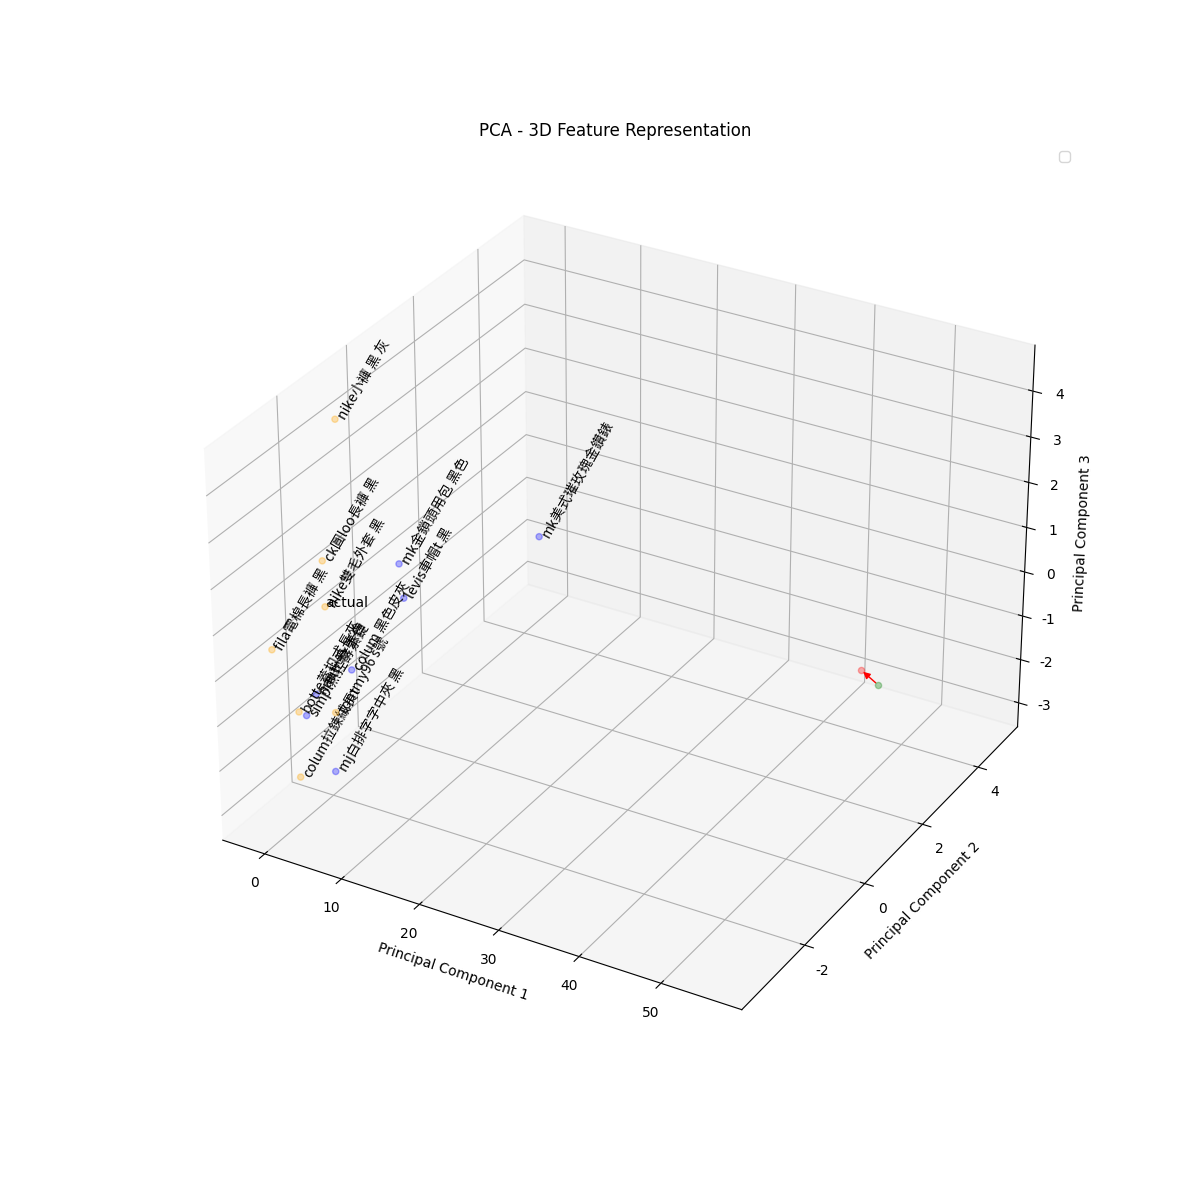

In [161]:
%matplotlib widget
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

for n in action_diff_uniq:
  ax.text(action_pca_df.loc[n, 0], action_pca_df.loc[n, 1], action_pca_df.loc[n, 2], item_names[n][:5]+item_names[n][-5:], (1, 1, 1), fontproperties=font1)
for n in action_nodiff_uniq:
  ax.text(action_pca_df.loc[n, 0], action_pca_df.loc[n, 1], action_pca_df.loc[n, 2], item_names[n][:5]+item_names[n][-5:], (1, 1, 1), fontproperties=font1)

# ax.scatter(action_pca_df.loc[true_bought_current, 0], action_pca_df.loc[true_bought_current, 1], action_pca_df.loc[true_bought_current, 2], color='cyan', alpha=.3)
ax.text(action_pca_df.loc[true_bought_current, 0], action_pca_df.loc[true_bought_current, 1], action_pca_df.loc[true_bought_current, 2], 'actual')
ax.scatter(action_pca_df.loc[action_diff_uniq, 0], action_pca_df.loc[action_diff_uniq, 1], action_pca_df.loc[action_diff_uniq, 2], color='orange', alpha=.3)
ax.scatter(action_pca_df.loc[action_nodiff_uniq, 0], action_pca_df.loc[action_nodiff_uniq, 1], action_pca_df.loc[action_nodiff_uniq, 2], color='blue', alpha=.3)

ax.scatter(action_pca_df.loc['action_diff', 0].mean(), action_pca_df.loc['action_diff', 1].mean(), action_pca_df.loc['action_diff', 2].mean(), color='red', alpha=.3)
ax.scatter(action_pca_df.loc['alpha', 0].mean(), action_pca_df.loc['alpha', 1].mean(), action_pca_df.loc['alpha', 2].mean(), color='green', alpha=.3)

from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)
        
a = Arrow3D([action_pca_df.loc['alpha', 0].mean(), action_pca_df.loc['action_diff', 0].mean()],
            [action_pca_df.loc['alpha', 1].mean(), action_pca_df.loc['action_diff', 1].mean()], 
            [action_pca_df.loc['alpha', 2].mean(), action_pca_df.loc['action_diff', 2].mean()],
            mutation_scale=10, 
            lw=1, arrowstyle="-|>", color="r")
ax.add_artist(a)

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('PCA - 3D Feature Representation')
plt.legend()
plt.show()

In [79]:
pca2 = PCA(n_components=2)
action_pca_2 = pca2.fit_transform(actions_emb_scaled)

action_pca_2_df = pd.DataFrame(action_pca_2, index=actions_emb.index)

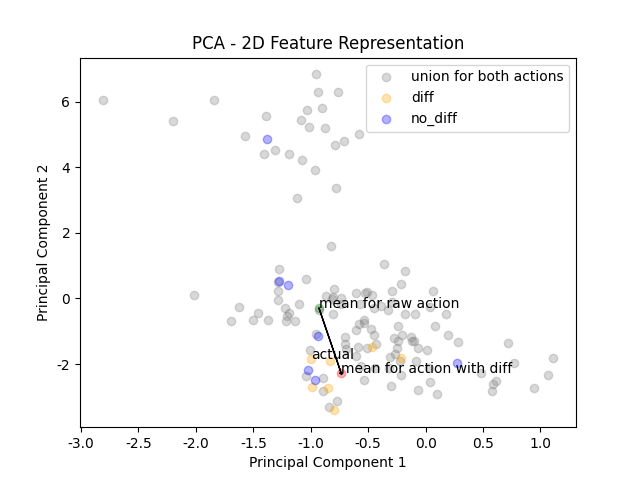

In [156]:
plt.figure(3)
# plt.scatter(action_pca_2_df.loc[actions_with_diff, 0], action_pca_2_df.loc[actions_with_diff, 1], label='diff')
# plt.scatter(action_pca_2[:, 0], action_pca_2[:, 1])
# true_bought_current

plt.scatter(action_pca_2_df.loc[action_union, 0], action_pca_2_df.loc[action_union, 1], label='union for both actions', color='grey', alpha=.3)
plt.annotate('actual', (action_pca_2_df.loc[true_bought_current, 0], action_pca_2_df.loc[true_bought_current, 1]))

plt.scatter(action_pca_2_df.loc[action_diff_uniq, 0], action_pca_2_df.loc[action_diff_uniq, 1], label='diff', color='orange', alpha=.3)
plt.scatter(action_pca_2_df.loc[action_diff_uniq, 0].mean(), action_pca_2_df.loc[action_diff_uniq, 1].mean(), color='red', alpha=.3)
plt.annotate('mean for action with diff', (action_pca_2_df.loc[action_diff_uniq, 0].mean(), action_pca_2_df.loc[action_diff_uniq, 1].mean()))

plt.scatter(action_pca_2_df.loc[action_nodiff_uniq, 0], action_pca_2_df.loc[action_nodiff_uniq, 1], label='no_diff', color='blue', alpha=.3)
plt.scatter(action_pca_2_df.loc[action_nodiff_uniq, 0].mean(), action_pca_2_df.loc[action_nodiff_uniq, 1].mean(), color='green', alpha=.3)
plt.annotate('mean for raw action', (action_pca_2_df.loc[action_nodiff_uniq, 0].mean(), action_pca_2_df.loc[action_nodiff_uniq, 1].mean()))

plt.arrow(action_pca_2_df.loc[action_nodiff_uniq, 0].mean(), 
          action_pca_2_df.loc[action_nodiff_uniq, 1].mean(),
          action_pca_2_df.loc[action_diff_uniq, 0].mean() - action_pca_2_df.loc[action_nodiff_uniq, 0].mean(),
          action_pca_2_df.loc[action_diff_uniq, 1].mean() - action_pca_2_df.loc[action_nodiff_uniq, 1].mean(),
          head_width=0.03)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA - 2D Feature Representation')
plt.legend()

In [108]:
true_bought_current = list(true_bought_current)[0]

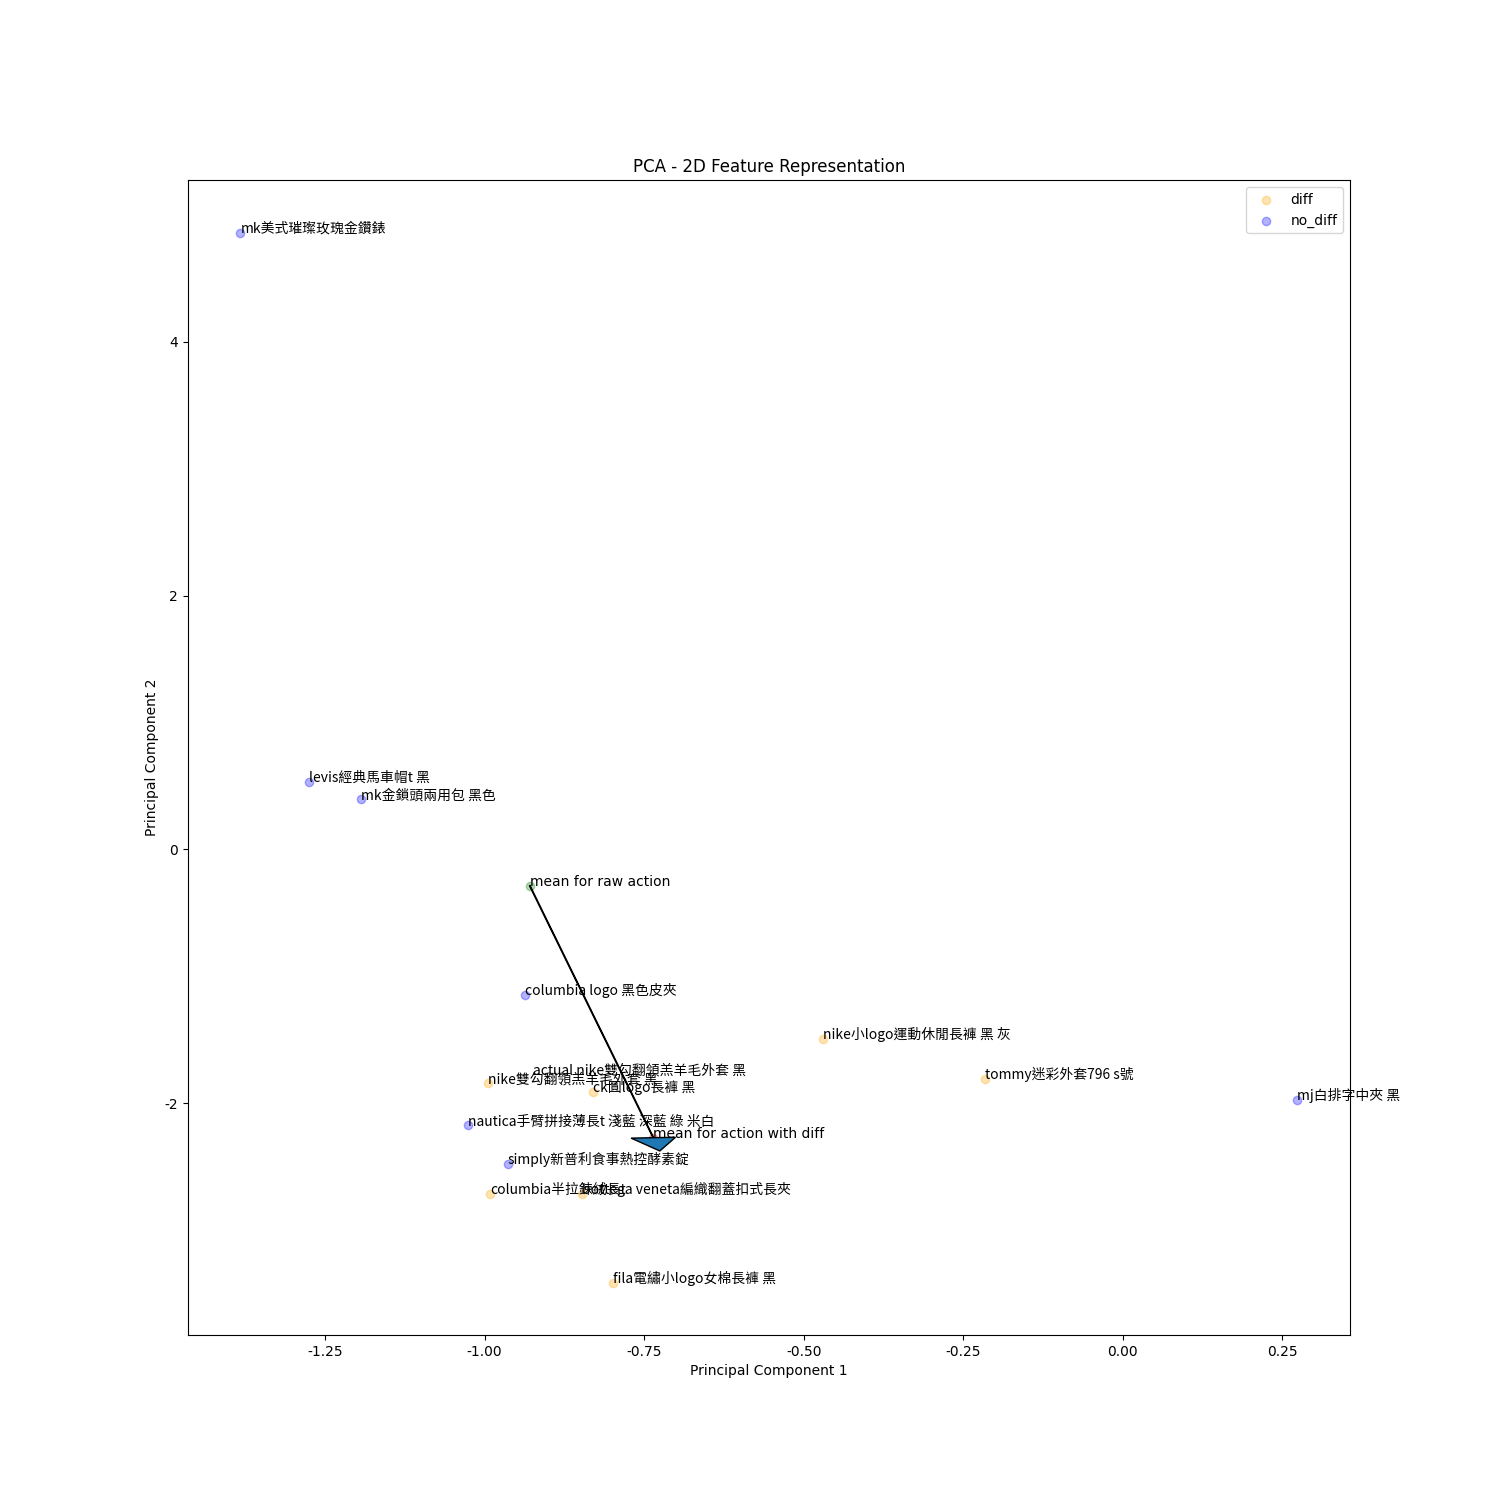

In [119]:
from matplotlib.font_manager import FontProperties as font
font1 = font(fname="../../data/NotoSansTC-Regular.otf")

fig = plt.figure(figsize=(15, 15))
# plt.scatter(action_pca_2_df.loc[actions_with_diff, 0], action_pca_2_df.loc[actions_with_diff, 1], label='diff')
# plt.scatter(action_pca_2[:, 0], action_pca_2[:, 1])

plt.annotate(f'actual {item_names[true_bought_current]}', (action_pca_2_df.loc[true_bought_current, 0]+.07, action_pca_2_df.loc[true_bought_current, 1]+.07), fontproperties=font1)

for n in action_diff_uniq:
  plt.annotate(item_names[n], (action_pca_2_df.loc[n, 0], action_pca_2_df.loc[n, 1]), fontproperties=font1)
for n in action_nodiff_uniq:
  plt.annotate(item_names[n], (action_pca_2_df.loc[n, 0], action_pca_2_df.loc[n, 1]), fontproperties=font1)
  
plt.scatter(action_pca_2_df.loc[action_diff_uniq, 0], action_pca_2_df.loc[action_diff_uniq, 1], label='diff', color='orange', alpha=.3)
  
plt.scatter(action_pca_2_df.loc[action_diff_uniq, 0].mean(), action_pca_2_df.loc[action_diff_uniq, 1].mean(), color='red', alpha=.3)
plt.annotate('mean for action with diff', (action_pca_2_df.loc[action_diff_uniq, 0].mean(), action_pca_2_df.loc[action_diff_uniq, 1].mean()))

plt.scatter(action_pca_2_df.loc[action_nodiff_uniq, 0], action_pca_2_df.loc[action_nodiff_uniq, 1], label='no_diff', color='blue', alpha=.3)
plt.scatter(action_pca_2_df.loc[action_nodiff_uniq, 0].mean(), action_pca_2_df.loc[action_nodiff_uniq, 1].mean(), color='green', alpha=.3)
plt.annotate('mean for raw action', (action_pca_2_df.loc[action_nodiff_uniq, 0].mean(), action_pca_2_df.loc[action_nodiff_uniq, 1].mean()))

plt.arrow(action_pca_2_df.loc[action_nodiff_uniq, 0].mean(), 
          action_pca_2_df.loc[action_nodiff_uniq, 1].mean(),
          action_pca_2_df.loc[action_diff_uniq, 0].mean() - action_pca_2_df.loc[action_nodiff_uniq, 0].mean(),
          action_pca_2_df.loc[action_diff_uniq, 1].mean() - action_pca_2_df.loc[action_nodiff_uniq, 1].mean(),
          head_width=0.07)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA - 2D Feature Representation')
plt.legend()

In [82]:
for a in actions_without_diff:
  print(item_names[a])

# '多功能泡麵碗', '廚房重油汙泡沫清潔劑', '亞羅椿煥采眼霜'

毛毯枕頭組
日本美樂圓餅
mk錶
chanel毛巾
毛毯
godiva可可粉 牛奶巧克力
星太郎點心麵禮盒組
ck圍巾
100支天絲豆豆被
海太馬鈴薯薄餅
tommy毛巾
godiva傳奇牛奶巧克力
韓國hair plus 免沖洗蛋白護髮精華
韓國elishacoy康普茶保濕精華
adidas三葉草老帽 黑
puma電繡帽 奶
韓國elishacoy康普茶保濕噴霧
薑黃維生素c b群
coach耳環
coac馬卡龍女錶
mk滿版托特包 黑
ea質感時尚典範男錶
adidas三葉草漁夫帽 白
ea探索世界三眼錶
nike大logo帽t 灰
ea7膠條小logo帽t 藍
tommy排字老帽 黑
韓國wellderma茶樹安瓶面膜
gucci 復古金頭 0593
all natural仙人掌修護面膜
adidas三葉草漁夫帽 黑
tommy滿版傘 藍
istkunst圓笑臉帽外 灰 黑 藍
timberland全黑衝風衣
tommy毛帽 黑 藍 灰
nice ghost club小熊大學t 黑 藍
海鷗棒球外套
lancome蘭蔻超未來肌因賦活露
nike小logo帽t 黑
tommy電繡小logo老帽 黑 卡
ea簍空機械男錶
nice ghost club粉螢光排字大熊大學t 黑
istkunst圓笑臉大學t 藍
智能發熱暖棉連帽外套
ck圍巾 黑
nike air jordan 棉外套 黑
ea運動咖啡橡膠三眼錶帶
韓國be plain綠豆弱酸性泡沫洗面乳
mk女款方包 黑
istkunst聯名nice ghost club米白色大學t
gucci滿版小logo圍巾
ea7短褲
ea時尚經典三眼運動錶
ea經典紳士三眼橡膠錶
nautica 男款帽tee 黑 灰
coach c7255 女款tote包 花色
coach外圈鑽簡約錶 金
adidas排字小側背 黑
adidas陰陽帽 黑
nike鞋盒運動包 黑
adidas大三線帽
simply新普利私密有酵蔓越莓c錠 30錠 盒
adidas愛迪達寶可夢聯名側背包
韓國wellderma深層保濕潔面乳
ea耀眼金銀三眼錶
tommy白鏡面鋼錶
levis白排字帽t 藍
tommy貼布logo女帽t 藍 黑
coach大馬車鋼錶 7658
thread supply大衣 黑 灰 奶
adidas三葉草電繡帽 粉
海鷗

In [132]:
for a in actions_with_diff:
  print(item_names[a])

nike swoosh 腰包
istkunst聯名nice ghost club米白色大學t
tommy立領科技布外套 黑520 xl號
tommy滿版傘 藍
韓國elishacoy康普茶保濕精華
istkunst圓笑臉大學t 藍
all natural仙人掌修護面膜
istkunst聯名nice ghost club藍色帽t
薑黃維生素c b群
法拉利手錶 模型車組


In [99]:
import matplotlib
print(matplotlib.__file__)

/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py


In [101]:
# mpl-data\fonts\ttf
!ls /usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/

afm  pdfcorefonts  ttf


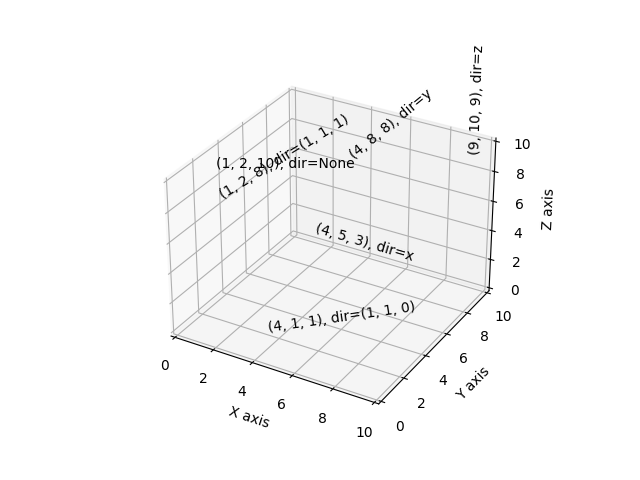

In [144]:
import matplotlib.pyplot as plt


ax = plt.figure().add_subplot(projection='3d')

# # Demo 1: zdir
zdirs = (None, 'x', 'y', 'z', (1, 1, 0), (1, 1, 1))
xs = (1, 4, 4, 9, 4, 1)
ys = (2, 5, 8, 10, 1, 2)
zs = (10, 3, 8, 9, 1, 8)

for zdir, x, y, z in zip(zdirs, xs, ys, zs):
    label = '(%d, %d, %d), dir=%s' % (x, y, z, zdir)
    ax.text(x, y, z, label, zdir)

# # Demo 2: color
# ax.text(9, 0, 0, "red", color='red')

# Demo 3: text2D
# Placement 0, 0 would be the bottom left, 1, 1 would be the top right.
# ax.text2D(0.05, 0.95, "2D Text", transform=ax.transAxes)

# Tweaking display region and labels
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.set_zlim(0, 10)
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

plt.show()